# ML Model for Madrid

This example contains an example using pyGAM

In [33]:
import sys
import os
import pandas as pd
from dotenv import load_dotenv

load_dotenv() # Load the environment variables from .env file

import importlib
# Añadir la ruta al directorio src para importar módulos personalizados
sys.path.append("../src")

# Unload the module if already loaded
import idealista18.loader as loader
import idealista18.enricher as enricher
import idealista18.util as util

os.makedirs("../models", exist_ok=True)

## Load data

In [34]:
# Load and clean data for Madrid
# Load data and remove outliers (spatial)
CITY = "Madrid"

df = enricher.load_enriched_data(city_name=CITY, 
                                          deduplicate_by_adid=True,
                                          enrich_census_code=False, 
                                          enrich_idealista_areas=False)


print("Data loaded:")
print(df.head())

Data loaded:
                 ASSETID   PRICE    UNITPRICE ADTYPOLOGYID ADOPERATIONID  \
0  A15019136831406238029  126000  2680.851064         HOME          SALE   
1   A6677225905472065344  235000  4351.851852         HOME          SALE   
2  A13341979748618524775  373000  4973.333333         HOME          SALE   
3   A4775182175615276542  284000  5916.666667         HOME          SALE   
4   A2492087730711701973  228000  4560.000000         HOME          SALE   

   CONSTRUCTEDAREA  ROOMNUMBER  BATHNUMBER  HASTERRACE  HASLIFT  ...  \
0               47           1           1           0        1  ...   
1               54           1           1           0        0  ...   
2               75           2           1           0        0  ...   
3               48           1           1           0        1  ...   
4               50           0           1           0        0  ...   

   DISTANCE_TO_METRO  DISTANCE_TO_CASTELLANA  LONGITUDE   LATITUDE  CITYNAME  \
0           0.872

### Outlier removal by zone

In [35]:
# Compute quartiles per LOCATIONID
stats = (
    df.groupby("LOCATIONID")["UNITPRICE"]
      .quantile([0.25, 0.5, 0.75])
      .unstack()
      .rename(columns={0.25: "Q1", 0.5: "Q2", 0.75: "Q3"})
)

# Compute bounds
stats["LOWER"] = stats["Q1"] - 3 * (stats["Q2"] - stats["Q1"])
stats["UPPER"] = stats["Q3"] + 3 * (stats["Q3"] - stats["Q2"])

# Join bounds back to original dataframe
df_filtered = df.merge(
    stats[["LOWER", "UPPER"]],
    left_on="LOCATIONID",
    right_index=True,
    how="left"
)

# Filter outliers
df_filtered = df_filtered[
    (df_filtered["UNITPRICE"] >= df_filtered["LOWER"]) &
    (df_filtered["UNITPRICE"] <= df_filtered["UPPER"])
]

# Optional: drop helper columns
df_filtered = df_filtered.drop(columns=["LOWER", "UPPER"])

print(f"Filtered data shape (after first iteration): {df_filtered.shape} - Total Removed: {round(100 - 100* df_filtered.shape[0] / df.shape[0],2)} %")

Filtered data shape (after first iteration): (73985, 48) - Total Removed: 2.4 %


### Outlier removal by ROOM and BATH NUMBER

In [36]:
# Mostrar valores máximo y mínimo para BATHNUMBER y ROOMNUMBER
min_max_values = df_filtered[['ROOMNUMBER', 'BATHNUMBER']].agg(['min', 'max'])
print("Valores máximo y mínimo para ROOMNUMBER y BATHNUMBER:\n")
print(min_max_values)

# Asignar valor 1 a los registros con valor 0 en ROOMNUMBER y BATHNUMBER
df_filtered.loc[df['ROOMNUMBER'] == 0, 'ROOMNUMBER'] = 1
df_filtered.loc[df['BATHNUMBER'] == 0, 'BATHNUMBER'] = 1

# Calcular los ratios ROOMNUMBER/CONSTRUCTEDAREA y BATHNUMBER/CONSTRUCTEDAREA
df_filtered['ROOMS_PER_AREA'] = df_filtered['ROOMNUMBER'] / df_filtered['CONSTRUCTEDAREA']
df_filtered['BATHS_PER_AREA'] = df_filtered['BATHNUMBER'] / df_filtered['CONSTRUCTEDAREA']

# Calcular la media y la desviación típica de los ratios
mean_rooms_per_area = df_filtered['ROOMS_PER_AREA'].mean()
std_rooms_per_area = df_filtered['ROOMS_PER_AREA'].std()

mean_baths_per_area = df_filtered['BATHS_PER_AREA'].mean()
std_baths_per_area = df_filtered['BATHS_PER_AREA'].std()

# Mostrar resultados
print(f"\nROOMS_PER_AREA (media / sd): {mean_rooms_per_area:3f} {std_rooms_per_area:3f}")
print(f"BATHS_PER_AREA (media / sd): {mean_baths_per_area:3f} {std_baths_per_area:3f}")

#
#   Identificar outliers en ROOMS_PER_AREA y BATHS_PER_AREA 
#
#   Calculados como 3 desviaciones típicas por encima de la media (solo lo hacemos para los valores altos)
#
threshold_rooms_per_area = mean_rooms_per_area + 3 * std_rooms_per_area
threshold_baths_per_area = mean_baths_per_area + 3 * std_baths_per_area

outliers_rooms = df_filtered[df_filtered['ROOMS_PER_AREA'] > threshold_rooms_per_area]
outliers_baths = df_filtered[df_filtered['BATHS_PER_AREA'] > threshold_baths_per_area]

# Contar registros que cumplen la condición
num_outliers_rooms = len(outliers_rooms)
num_outliers_baths = len(outliers_baths)

print(f"\nNúmero de outliers en ROOMS_PER_AREA: {num_outliers_rooms}")
print(f"Número de outliers en BATHS_PER_AREA: {num_outliers_baths}")

# Eliminar registros outliers del dataframe
df_filtered = df_filtered[~df_filtered.index.isin(outliers_rooms.index)]
df_filtered = df_filtered[~df_filtered.index.isin(outliers_baths.index)]

print(f"Filtered data shape (after second iteration): {df_filtered.shape} - Total Removed: {round(100 - 100* df_filtered.shape[0] / df.shape[0],2)} %")

Valores máximo y mínimo para ROOMNUMBER y BATHNUMBER:

     ROOMNUMBER  BATHNUMBER
min           0           0
max          33          18

ROOMS_PER_AREA (media / sd): 0.029104 0.010418
BATHS_PER_AREA (media / sd): 0.017220 0.005848

Número de outliers en ROOMS_PER_AREA: 382
Número de outliers en BATHS_PER_AREA: 996
Filtered data shape (after second iteration): (72661, 50) - Total Removed: 4.14 %


In [37]:
TARGET_COLUMN = "UNITPRICE"

df_work = df_filtered[['UNITPRICE', 'ROOMNUMBER', 'CONSTRUCTEDAREA', 'HASLIFT', 
              'HASTERRACE', 'CADASTRALQUALITYID', 'DISTANCE_TO_METRO', 
              'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
              'LATITUDE', 'LONGITUDE']]

Create a matrix (covariates) and a vector (target)

In [38]:
# Prepare features and target variable
df_model = df_work.dropna().copy()
X = df_model.drop(columns=[TARGET_COLUMN])
y = df_model[TARGET_COLUMN]
print(f'Features shape: {X.shape} | Target shape: {y.shape}')


Features shape: (72660, 11) | Target shape: (72660,)


## GAM model with spatial spline


In [39]:
import numpy as np
from pygam import LinearGAM, s, te, l
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

features = [
    'ROOMNUMBER',
    'CONSTRUCTEDAREA',
    'HASLIFT',
    'HASTERRACE',
    'CADASTRALQUALITYID',
    'DISTANCE_TO_METRO',
    'BUILTTYPEID_1',
    'BUILTTYPEID_2',
    'BUILTTYPEID_3',
    'LATITUDE',
    'LONGITUDE',
]

X = df_model[features].copy()
y = df_model[TARGET_COLUMN].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

idx = {col: i for i, col in enumerate(features)}

terms = (
    te(idx['LATITUDE'], idx['LONGITUDE'], n_splines=(50,50)) +
    s(idx['CONSTRUCTEDAREA']) + # 0
    l(idx['ROOMNUMBER']) + # 1
    l(idx['HASLIFT']) + # 2
    l(idx['HASTERRACE']) + # 3
    l(idx['CADASTRALQUALITYID']) + # 4
    s(idx['DISTANCE_TO_METRO']) + # 5
    l(idx['BUILTTYPEID_1']) + # 6
    l(idx['BUILTTYPEID_2']) + # 7
    l(idx['BUILTTYPEID_3']) # 8
)

gam = LinearGAM(terms).fit(X_train.values, y_train.values)
print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     460.219
Link Function:                     IdentityLink Log Likelihood:                               -466628.4983
Number of Samples:                        58128 AIC:                                           934179.4347
                                                AICc:                                          934186.8285
                                                GCV:                                            562186.792
                                                Scale:                                            744.4331
                                                Pseudo R-Squared:                                   0.8029
Feature Function                  Lam

/var/folders/c8/4vzgjk5s1rd15q7tw2p8d9040000gn/T/ipykernel_22350/878299472.py:46: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


## Model performance (MAE, RMSE, MAPE)


In [40]:
import math

y_pred = gam.predict(X_test.values)

mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))

eps = 1e-8
mape = np.mean(np.abs((y_test.values - y_pred) / (y_test.values + eps))) * 100

print(f'MAE:  {mae:,.2f}')
print(f'RMSE: {rmse:,.2f}')
print(f'MAPE: {mape:,.2f}%')


MAE:  538.87
RMSE: 740.59
MAPE: 16.19%


## Residual analysis


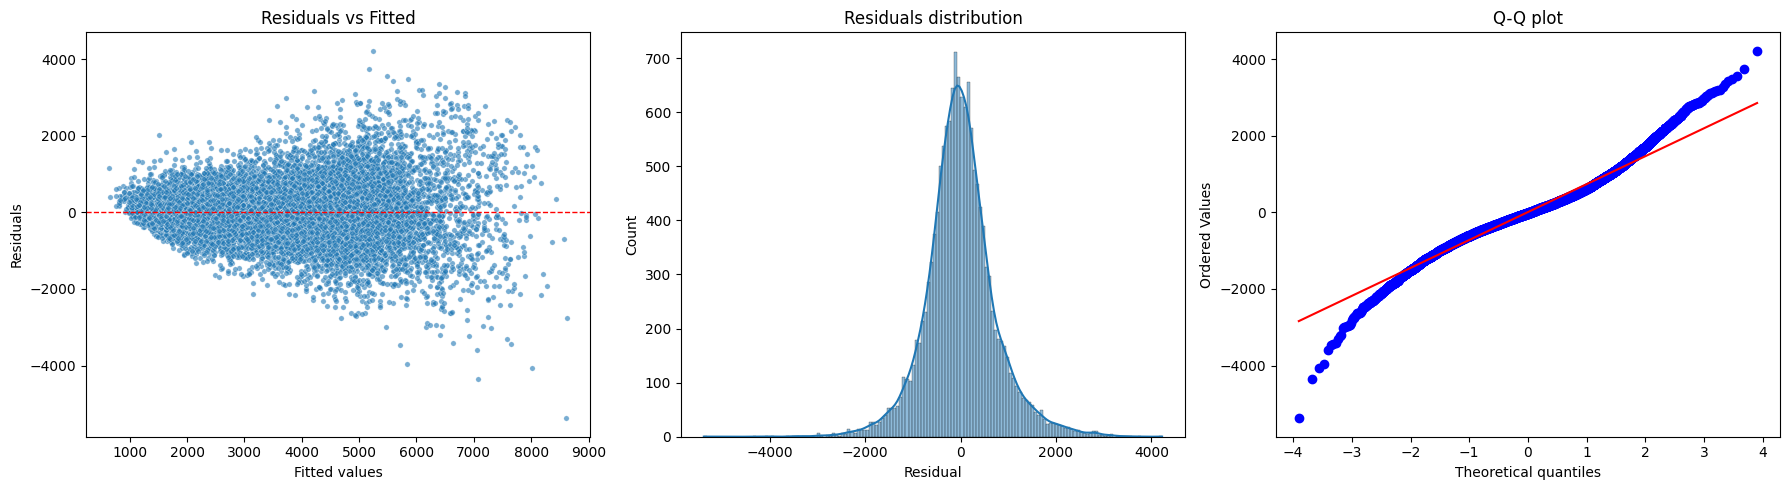

In [41]:
residuals = y_test.values - y_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x=y_pred, y=residuals, ax=axes[0], s=15, alpha=0.6)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Residuals vs Fitted')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')

sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_title('Residuals distribution')
axes[1].set_xlabel('Residual')

stats.probplot(residuals, dist='norm', plot=axes[2])
axes[2].set_title('Q-Q plot')

plt.tight_layout()


## 2D grid predictions (100x100)


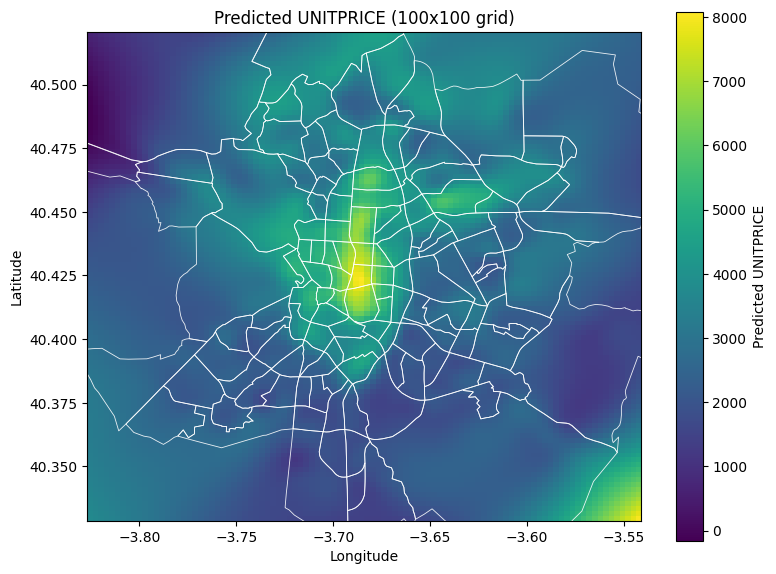

In [42]:
n_grid = 100

lat_min, lat_max = df_model['LATITUDE'].min(), df_model['LATITUDE'].max()
lon_min, lon_max = df_model['LONGITUDE'].min(), df_model['LONGITUDE'].max()

lat_edges = np.linspace(lat_min, lat_max, n_grid + 1)
lon_edges = np.linspace(lon_min, lon_max, n_grid + 1)
lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2

lon_grid, lat_grid = np.meshgrid(lon_centers, lat_centers)

binary_cols = {'HASLIFT', 'HASTERRACE', 'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3'}
fixed_values = {}
for col in features:
    if col in ['LATITUDE', 'LONGITUDE']:
        continue
    if col in binary_cols:
        fixed_values[col] = int(df_model[col].mode().iloc[0])
    else:
        fixed_values[col] = float(df_model[col].median())

grid_df = pd.DataFrame({
    'LATITUDE': lat_grid.ravel(),
    'LONGITUDE': lon_grid.ravel(),
})

for col, val in fixed_values.items():
    grid_df[col] = val

grid_df = grid_df[features]
grid_pred = gam.predict(grid_df.values)

price_grid = grid_pred.reshape(n_grid, n_grid)
price_grid_complete = price_grid

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(price_grid, origin='lower', aspect='auto',
               extent=[lon_min, lon_max, lat_min, lat_max])
fig.colorbar(im, ax=ax, label='Predicted UNITPRICE')
ax.set_title('Predicted UNITPRICE (100x100 grid)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Overlay city polygons (Idealista zones)
try:
    gdf_polygons = loader.load_geo_idealista_zones(city_name=CITY, use_geopandas=True)
    gdf_polygons.boundary.plot(ax=ax, color='white', linewidth=0.6, alpha=0.9)
except Exception as e:
    print(f'Could not overlay polygons: {e}')

# Keep axes aligned with grid extent
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
plt.tight_layout()


## Create a pure location mode

In [43]:
import numpy as np
from pygam import LinearGAM, s, te, l
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

features = [
    'LATITUDE',
    'LONGITUDE',
]

X = df_model[features].copy()
y = df_model[TARGET_COLUMN].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

idx = {col: i for i, col in enumerate(features)}

terms = (
    te(idx['LATITUDE'], idx['LONGITUDE'], n_splines=(50,50)) 
)

gam_loc = LinearGAM(terms).fit(X_train.values, y_train.values)
print(gam_loc.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    434.7018
Link Function:                     IdentityLink Log Likelihood:                               -471897.2427
Number of Samples:                        58128 AIC:                                           944665.8889
                                                AICc:                                          944672.4852
                                                GCV:                                           673087.8104
                                                Scale:                                            814.8825
                                                Pseudo R-Squared:                                   0.7638
Feature Function                  Lam

/var/folders/c8/4vzgjk5s1rd15q7tw2p8d9040000gn/T/ipykernel_22350/648192554.py:28: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam_loc.summary())


In [44]:
import math

y_pred = gam_loc.predict(X_test.values)

mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))

eps = 1e-8
mape = np.mean(np.abs((y_test.values - y_pred) / (y_test.values + eps))) * 100

print(f'MAE (LOC):  {mae:,.2f}')
print(f'RMSE (LOC): {rmse:,.2f}')
print(f'MAPE (LOC): {mape:,.2f}%')


MAE (LOC):  602.19
RMSE (LOC): 813.90
MAPE (LOC): 18.25%


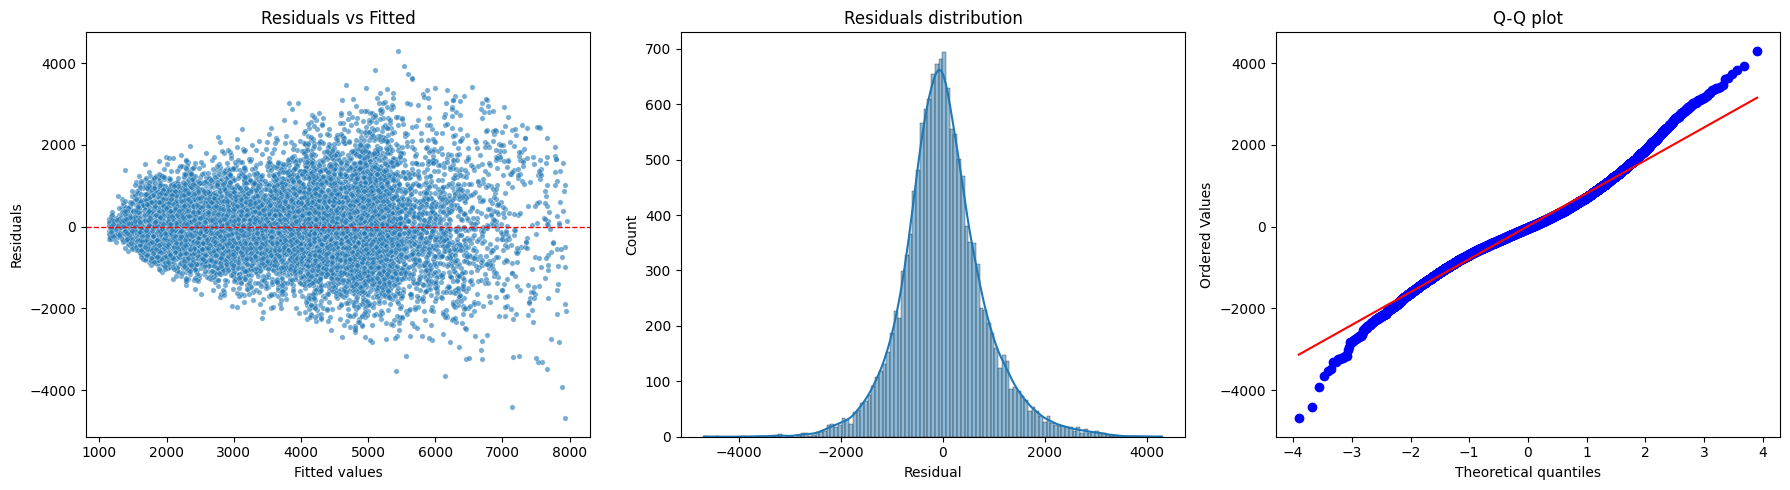

In [45]:
residuals = y_test.values - y_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x=y_pred, y=residuals, ax=axes[0], s=15, alpha=0.6)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Residuals vs Fitted')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')

sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_title('Residuals distribution')
axes[1].set_xlabel('Residual')

stats.probplot(residuals, dist='norm', plot=axes[2])
axes[2].set_title('Q-Q plot')

plt.tight_layout()


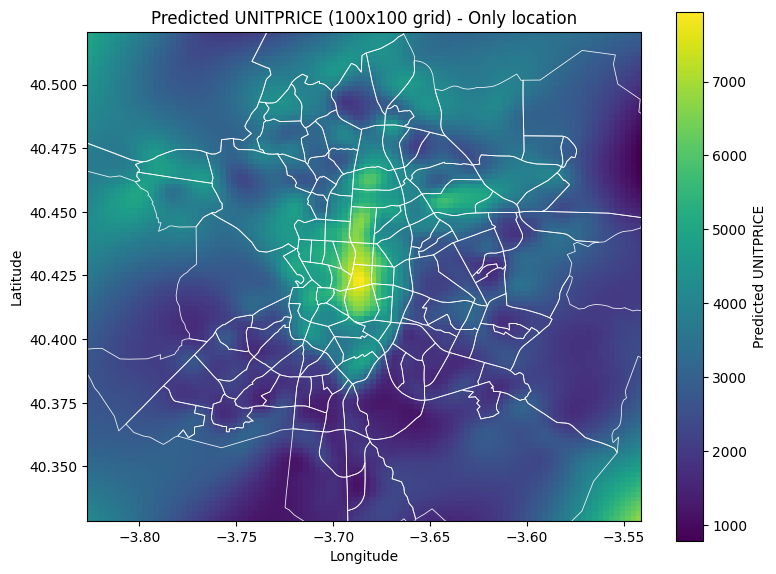

In [46]:
n_grid = 100

lat_min, lat_max = df_model['LATITUDE'].min(), df_model['LATITUDE'].max()
lon_min, lon_max = df_model['LONGITUDE'].min(), df_model['LONGITUDE'].max()

lat_edges = np.linspace(lat_min, lat_max, n_grid + 1)
lon_edges = np.linspace(lon_min, lon_max, n_grid + 1)
lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2

lon_grid, lat_grid = np.meshgrid(lon_centers, lat_centers)

for col in features:
    if col in ['LATITUDE', 'LONGITUDE']:
        continue

grid_df = pd.DataFrame({
    'LATITUDE': lat_grid.ravel(),
    'LONGITUDE': lon_grid.ravel(),
})

for col, val in fixed_values.items():
    grid_df[col] = val

grid_df = grid_df[features]
grid_pred = gam_loc.predict(grid_df.values)

price_grid = grid_pred.reshape(n_grid, n_grid)
price_grid_location = price_grid

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(price_grid, origin='lower', aspect='auto',
               extent=[lon_min, lon_max, lat_min, lat_max])
fig.colorbar(im, ax=ax, label='Predicted UNITPRICE')
ax.set_title('Predicted UNITPRICE (100x100 grid) - Only location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Overlay city polygons (Idealista zones)
try:
    gdf_polygons = loader.load_geo_idealista_zones(city_name=CITY, use_geopandas=True)
    gdf_polygons.boundary.plot(ax=ax, color='white', linewidth=0.6, alpha=0.9)
except Exception as e:
    print(f'Could not overlay polygons: {e}')

# Keep axes aligned with grid extent
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
plt.tight_layout()


# Spatial intercept + tree

## Tree model using GAM spatial grid (replace LAT/LON)


### Use only location grid

In [47]:
from sklearn.tree import DecisionTreeRegressor

# Map each observation to a grid cell and use the GAM spatial grid value
lat_idx = np.clip(np.searchsorted(lat_edges, df_model['LATITUDE'].values, side='right') - 1, 0, n_grid - 1)
lon_idx = np.clip(np.searchsorted(lon_edges, df_model['LONGITUDE'].values, side='right') - 1, 0, n_grid - 1)
grid_price_for_obs = price_grid_location[lat_idx, lon_idx]

tree_features = [
    'ROOMNUMBER',
    'CONSTRUCTEDAREA',
    'HASLIFT',
    'HASTERRACE',
    'CADASTRALQUALITYID',
    'DISTANCE_TO_METRO',
    'BUILTTYPEID_1',
    'BUILTTYPEID_2',
    'BUILTTYPEID_3',
    'GRID_UNITPRICE',
]

df_tree = df_model.copy()
df_tree['GRID_UNITPRICE'] = grid_price_for_obs
X_tree = df_tree[tree_features]
y_tree = df_tree[TARGET_COLUMN]

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_tree, y_tree, test_size=0.2, random_state=42
)

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train_t, y_train_t)

y_pred_t = tree.predict(X_test_t)

mae_t = mean_absolute_error(y_test_t, y_pred_t)
rmse_t = math.sqrt(mean_squared_error(y_test_t, y_pred_t))
mape_t = np.mean(np.abs((y_test_t.values - y_pred_t) / (y_test_t.values + eps))) * 100

print(f'Tree MAE:  {mae_t:,.2f}')
print(f'Tree RMSE: {rmse_t:,.2f}')
print(f'Tree MAPE: {mape_t:,.2f}%')


Tree MAE:  610.84
Tree RMSE: 910.86
Tree MAPE: 18.17%


In [48]:
from sklearn.tree import DecisionTreeRegressor

# Map each observation to a grid cell and use the GAM spatial grid value
lat_idx = np.clip(np.searchsorted(lat_edges, df_model['LATITUDE'].values, side='right') - 1, 0, n_grid - 1)
lon_idx = np.clip(np.searchsorted(lon_edges, df_model['LONGITUDE'].values, side='right') - 1, 0, n_grid - 1)
grid_price_for_obs = price_grid_complete[lat_idx, lon_idx]

tree_features = [
    'ROOMNUMBER',
    'CONSTRUCTEDAREA',
    'HASLIFT',
    'HASTERRACE',
    'CADASTRALQUALITYID',
    'DISTANCE_TO_METRO',
    'BUILTTYPEID_1',
    'BUILTTYPEID_2',
    'BUILTTYPEID_3',
    'GRID_UNITPRICE',
]

df_tree = df_model.copy()
df_tree['GRID_UNITPRICE'] = grid_price_for_obs
X_tree = df_tree[tree_features]
y_tree = df_tree[TARGET_COLUMN]

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_tree, y_tree, test_size=0.2, random_state=42
)

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train_t, y_train_t)


,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_l

In [49]:
y_pred_t = tree.predict(X_test_t)

r2_rf = r2_score(y_test_t, y_pred_t)
mae_t = mean_absolute_error(y_test_t, y_pred_t)
rmse_t = math.sqrt(mean_squared_error(y_test_t, y_pred_t))
mape_t = np.mean(np.abs((y_test_t.values - y_pred_t) / (y_test_t.values + eps))) * 100
medape_rf = np.median(np.abs((y_test_t.values - y_pred_t) / (y_test_t.values + eps))) * 100


print(f'R2:  {r2_rf:,.2f}')
print(f'Tree MAE:  {mae_t:,.2f}')
print(f'Tree RMSE: {rmse_t:,.2f}')
print(f'Tree MAPE: {mape_t:,.2f}%')
print(f'RF MedAPE: {medape_rf:,.2f}%')

R2:  0.70
Tree MAE:  611.28
Tree RMSE: 917.07
Tree MAPE: 18.09%
RF MedAPE: 12.14%


### Use complete model grid

## Tree residual analysis


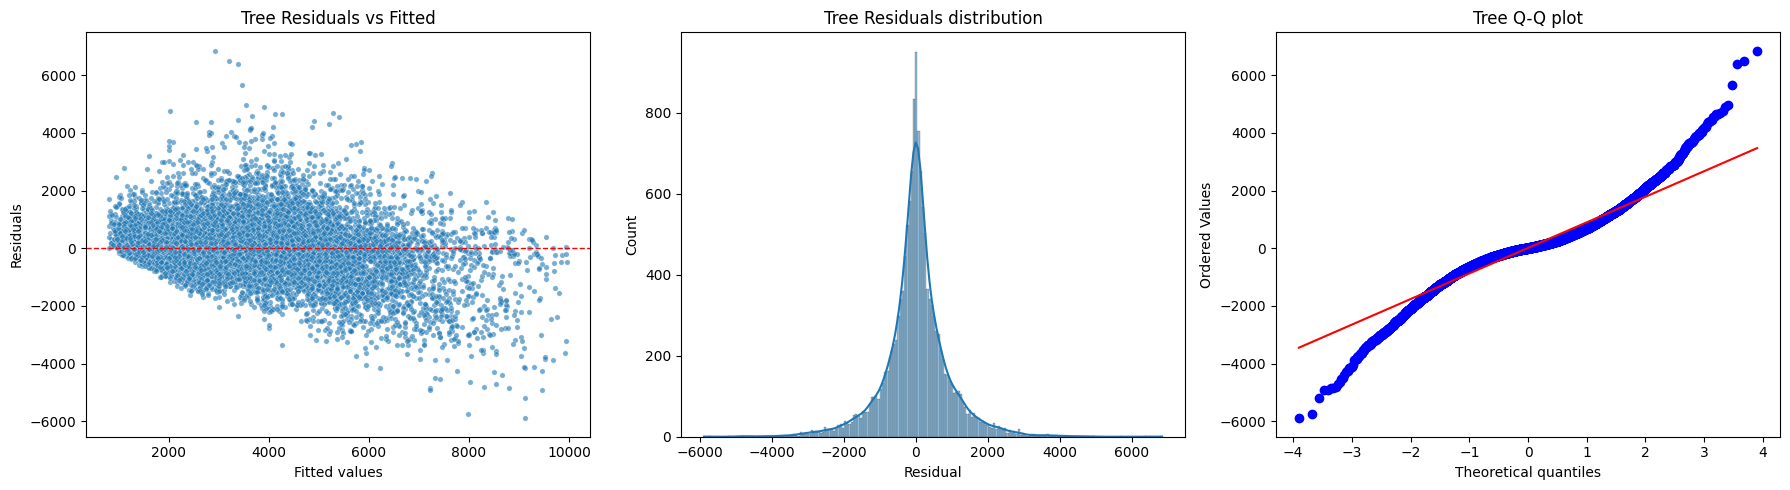

In [50]:
residuals_t = y_test_t.values - y_pred_t

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x=y_pred_t, y=residuals_t, ax=axes[0], s=15, alpha=0.6)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Tree Residuals vs Fitted')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')

sns.histplot(residuals_t, kde=True, ax=axes[1])
axes[1].set_title('Tree Residuals distribution')
axes[1].set_xlabel('Residual')

stats.probplot(residuals_t, dist='norm', plot=axes[2])
axes[2].set_title('Tree Q-Q plot')

plt.tight_layout()


## Random forest model using GAM spatial grid (replace LAT/LON)


In [51]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=250,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_t, y_train_t)




,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",250
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [52]:
y_pred_rf = rf.predict(X_test_t)

y_pred_rf = rf.predict(X_test_t)

mae_rf = mean_absolute_error(y_test_t, y_pred_rf)
rmse_rf = math.sqrt(mean_squared_error(y_test_t, y_pred_rf))
mape_rf = np.mean(np.abs((y_test_t.values - y_pred_rf) / (y_test_t.values + eps))) * 100
medape_rf = np.median(np.abs((y_test_t.values - y_pred_rf) / (y_test_t.values + eps))) * 100

r2_rf = r2_score(y_test_t, y_pred_rf)

print(f'R2:  {r2_rf:,.2f}')
print(f'RF MAE:  {mae_rf:,.2f}')
print(f'RF RMSE: {rmse_rf:,.2f}')
print(f'RF MAPE: {mape_rf:,.2f}%')
print(f'RF MedAPE: {medape_rf:,.2f}%')

R2:  0.84
RF MAE:  458.17
RF RMSE: 662.23
RF MAPE: 13.74%
RF MedAPE: 9.68%


## Random forest residual analysis


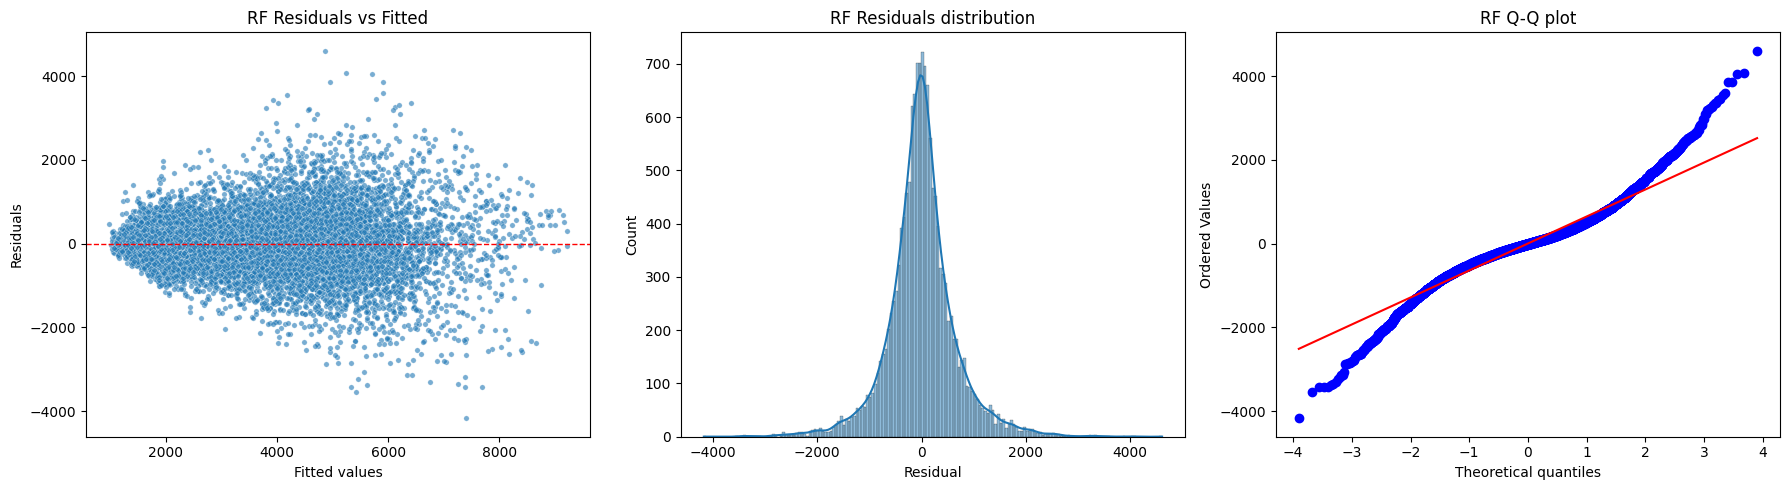

In [53]:
residuals_rf = y_test_t.values - y_pred_rf

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x=y_pred_rf, y=residuals_rf, ax=axes[0], s=15, alpha=0.6)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('RF Residuals vs Fitted')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')

sns.histplot(residuals_rf, kde=True, ax=axes[1])
axes[1].set_title('RF Residuals distribution')
axes[1].set_xlabel('Residual')

stats.probplot(residuals_rf, dist='norm', plot=axes[2])
axes[2].set_title('RF Q-Q plot')

plt.tight_layout()


## MAPE aggregated per polygon (Idealista zones)


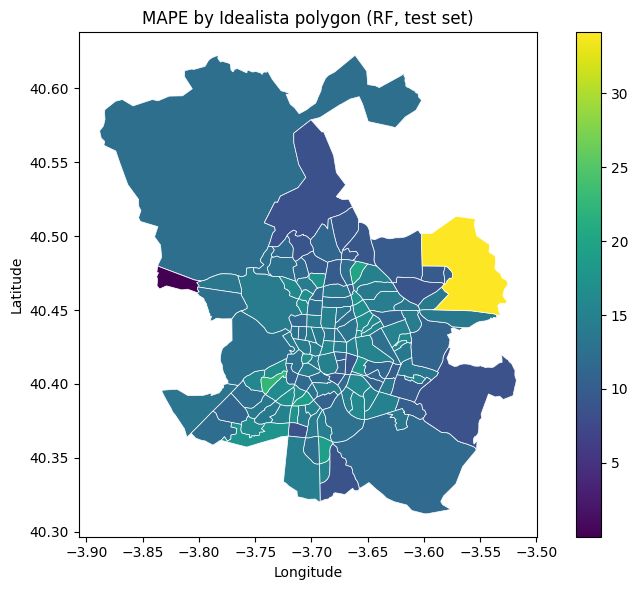

In [54]:
import geopandas as gpd
from shapely.geometry import Point

# Use RF predictions on the test set for polygon-level MAPE
test_idx = X_test_t.index
df_test_points = df_tree.loc[test_idx, ['LATITUDE', 'LONGITUDE']].copy()
df_test_points['y_true'] = y_test_t.values
df_test_points['y_pred'] = y_pred_rf

eps = 1e-8
df_test_points['mape'] = np.abs((df_test_points['y_true'] - df_test_points['y_pred']) / (df_test_points['y_true'] + eps)) * 100

geometry = [Point(xy) for xy in zip(df_test_points['LONGITUDE'], df_test_points['LATITUDE'])]
gdf_points = gpd.GeoDataFrame(df_test_points, geometry=geometry, crs='EPSG:4326')

gdf_polygons = loader.load_geo_idealista_zones(city_name=CITY, use_geopandas=True)
gdf_join = gpd.sjoin(gdf_points, gdf_polygons, how='left', predicate='within')

mape_by_poly = gdf_join.groupby('LOCATIONID', dropna=True)['mape'].mean().reset_index()

gdf_polygons_mape = gdf_polygons.merge(mape_by_poly, on='LOCATIONID', how='left')

fig, ax = plt.subplots(figsize=(8, 6))
gdf_polygons_mape.plot(column='mape', cmap='viridis', legend=True,
                       ax=ax, edgecolor='white', linewidth=0.5)
ax.set_title('MAPE by Idealista polygon (RF, test set)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()


### R2 by location

/var/folders/c8/4vzgjk5s1rd15q7tw2p8d9040000gn/T/ipykernel_22350/4260554277.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


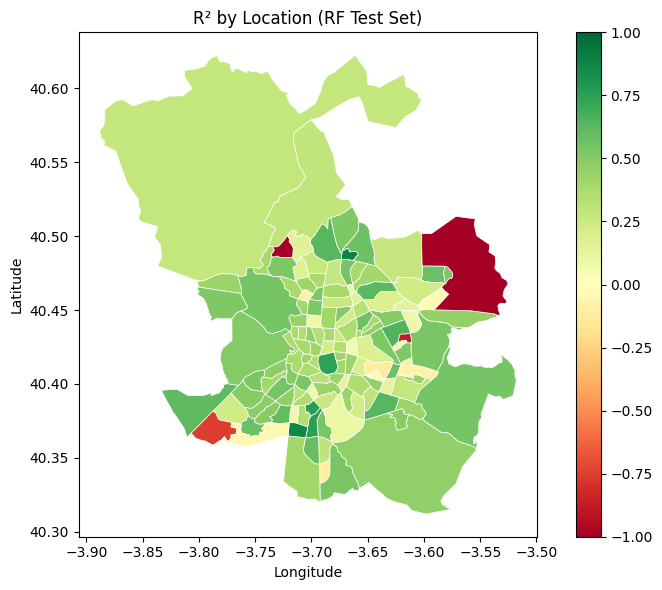

In [70]:
# Compute R² per polygon
r2_by_location = (
    gdf_join
    .groupby("LOCATIONNAME")
    .apply(
        lambda x: r2_score(x["y_true"], x["y_pred"])
        if len(x) > 1 else np.nan
    )
    .reset_index(name="R2")
)

# Merge with polygon GeoDataFrame
gdf_polygons_r2 = gdf_polygons.merge(
    r2_by_location,
    on="LOCATIONNAME",
    how="left"
)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

gdf_polygons_r2.plot(
    column="R2",
    cmap="RdYlGn",
    legend=True,
    ax=ax,
    edgecolor="white",
    linewidth=0.5,
    vmin=-1,
    vmax=1
)

ax.set_title("R² by Location (RF Test Set)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

We display all areas with extreme errors (highest & lowest)

In [75]:
import numpy as np

# ---- Compute per-point errors ----
gdf_join["abs_error"] = np.abs(gdf_join["y_true"] - gdf_join["y_pred"])
gdf_join["ape"] = np.abs(
    (gdf_join["y_true"] - gdf_join["y_pred"]) / (gdf_join["y_true"] + 1e-8)
) * 100

# ---- Aggregate metrics per LOCATIONID ----
metrics_by_location = (
    gdf_join
    .groupby("LOCATIONNAME")
    .apply(lambda x: pd.Series({
        "R2": r2_score(x["y_true"], x["y_pred"]) if len(x) > 1 else np.nan,
        "MAE": np.mean(np.abs(x["y_true"] - x["y_pred"])),
        "MAPE": np.mean(np.abs((x["y_true"] - x["y_pred"]) / (x["y_true"] + 1e-8))) * 100,
        "MEDAPE": np.median(np.abs((x["y_true"] - x["y_pred"]) / (x["y_true"] + 1e-8))) * 100,
        "N": len(x)
    }))
    .reset_index()
)

# ---- Sort by MAPE ----
metrics_sorted = metrics_by_location.sort_values("MAPE")

# ---- Print results ----
print("\n===== 🔽 5 LOWEST MAPE LOCATIONS =====")
print(metrics_sorted.head(5).to_string(index=False))

print("\n===== 🔼 5 HIGHEST MAPE LOCATIONS =====")
print(metrics_sorted.tail(5).to_string(index=False))


===== 🔽 5 LOWEST MAPE LOCATIONS =====
                 LOCATIONNAME       R2        MAE     MAPE   MEDAPE    N
                   El Plantío      NaN   0.259231 0.006492 0.006492  1.0
                 Montecarmelo 0.291261 396.206064 8.467945 8.792668 31.0
El Cañaveral - Los Berrocales 0.548443 166.809507 8.542720 6.458523 63.0
                    Orcasitas 0.866754 144.020392 8.661680 7.135452 50.0
                     Butarque 0.537418 158.900465 8.776405 5.923067 87.0

===== 🔼 5 HIGHEST MAPE LOCATIONS =====
    LOCATIONNAME        R2        MAE      MAPE    MEDAPE    N
        Moscardó  0.374678 369.626191 18.925421 12.343015 97.0
     Los Rosales  0.302276 278.878917 19.025310 12.693206 87.0
Apóstol Santiago  0.387681 467.808174 20.013774 13.524286 44.0
    Los Cármenes  0.405887 413.397726 22.533843 11.737471 58.0
      Aeropuerto -4.102835 494.531542 34.120478 15.641339  6.0


/var/folders/c8/4vzgjk5s1rd15q7tw2p8d9040000gn/T/ipykernel_22350/3087942245.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


We display the average seen by area compared with the global metrics, in order to see there are (in general a spatial distributed pattern)

In [78]:
import pandas as pd
import numpy as np

# ---- Average metrics across locations ----
location_avg = metrics_by_location[["MAPE", "MAE", "MEDAPE", "R2"]].mean()

# ---- Global RF metrics ----
global_metrics = pd.Series({
    "MAPE": mape_rf,
    "MAE": mae_rf,
    "MEDAPE": medape_rf,
    "R2": r2_rf

})

# ---- Build comparison table ----
comparison_df = pd.DataFrame({
    "Global_RF": global_metrics,
    "Location_Avg": location_avg
})

# ---- % Difference (Location Avg vs Global) ----
comparison_df["Pct_Diff_%"] = (
    (comparison_df["Location_Avg"] - comparison_df["Global_RF"])
    / comparison_df["Global_RF"]
) * 100

# ---- Pretty formatting ----
comparison_df = comparison_df.round(3)

print("\n===== GLOBAL vs LOCATION-LEVEL METRICS =====")
print(comparison_df)


===== GLOBAL vs LOCATION-LEVEL METRICS =====
        Global_RF  Location_Avg  Pct_Diff_%
MAPE       13.739        13.488      -1.824
MAE       458.167       417.712      -8.830
MEDAPE      9.675         9.484      -1.978
R2          0.844         0.319     -62.198


## RF residuals on 100x100 grid (observed vs predicted per cell)


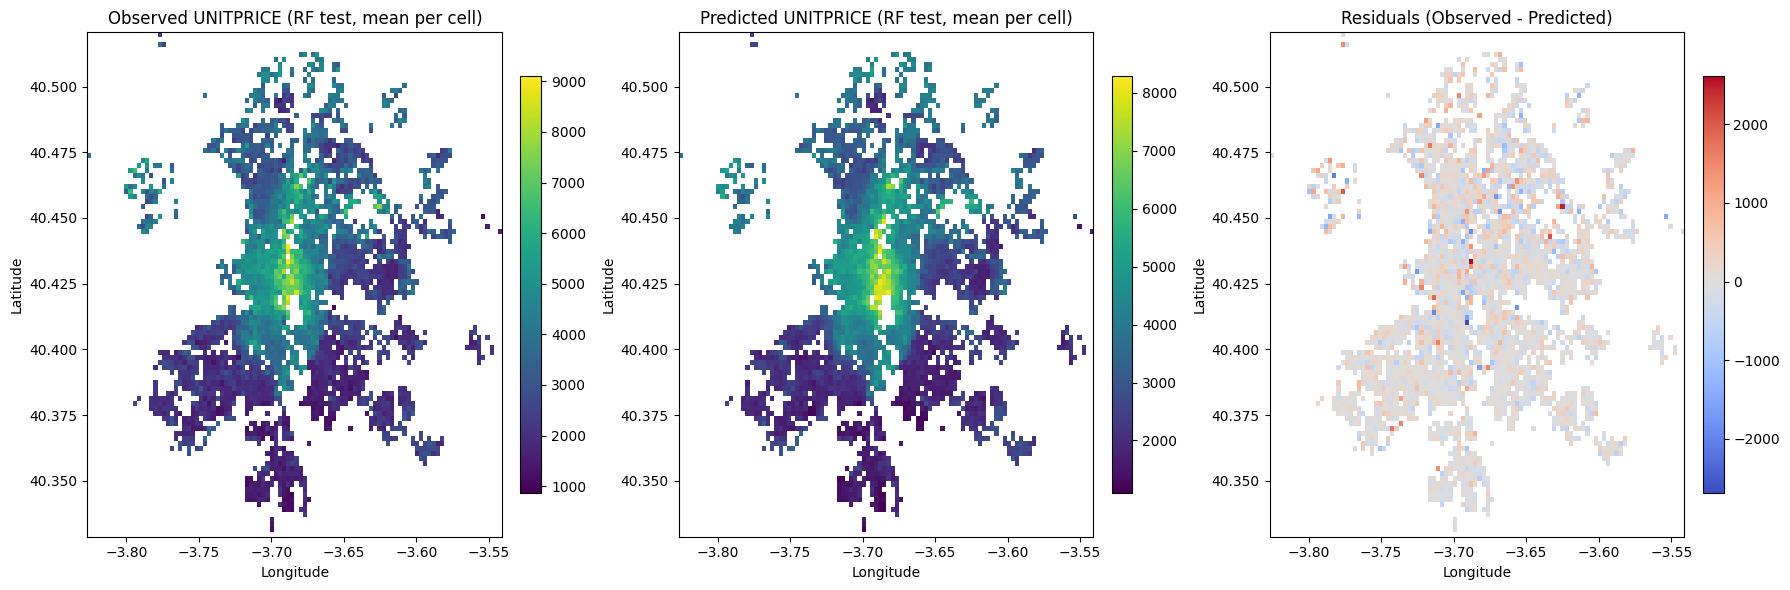

In [55]:
# Map RF test predictions/observations to grid cells and aggregate
test_idx = X_test_t.index
df_grid_res = df_tree.loc[test_idx, ['LATITUDE', 'LONGITUDE']].copy()
df_grid_res['y_true'] = y_test_t.values
df_grid_res['y_pred'] = y_pred_rf

lat_idx = np.clip(np.searchsorted(lat_edges, df_grid_res['LATITUDE'].values, side='right') - 1, 0, n_grid - 1)
lon_idx = np.clip(np.searchsorted(lon_edges, df_grid_res['LONGITUDE'].values, side='right') - 1, 0, n_grid - 1)
df_grid_res['lat_idx'] = lat_idx
df_grid_res['lon_idx'] = lon_idx

agg = (
    df_grid_res.groupby(['lat_idx', 'lon_idx'])[['y_true', 'y_pred']]
    .mean()
    .reset_index()
)
agg['residual'] = agg['y_true'] - agg['y_pred']

res_grid = np.full((n_grid, n_grid), np.nan)
obs_grid = np.full((n_grid, n_grid), np.nan)
pred_grid = np.full((n_grid, n_grid), np.nan)

for _, row in agg.iterrows():
    i = int(row['lat_idx'])
    j = int(row['lon_idx'])
    obs_grid[i, j] = row['y_true']
    pred_grid[i, j] = row['y_pred']
    res_grid[i, j] = row['residual']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im0 = axes[0].imshow(obs_grid, origin='lower', aspect='auto',
                     extent=[lon_min, lon_max, lat_min, lat_max])
axes[0].set_title('Observed UNITPRICE (RF test, mean per cell)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(pred_grid, origin='lower', aspect='auto',
                     extent=[lon_min, lon_max, lat_min, lat_max])
axes[1].set_title('Predicted UNITPRICE (RF test, mean per cell)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(res_grid, origin='lower', aspect='auto',
                     extent=[lon_min, lon_max, lat_min, lat_max], cmap='coolwarm')
axes[2].set_title('Residuals (Observed - Predicted)')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()


## RF MAPE grid + residual histograms (per cell)


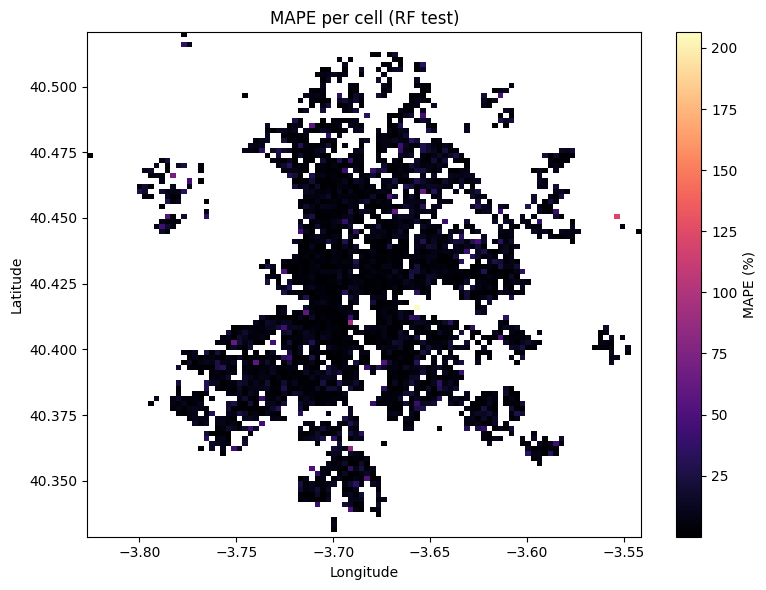

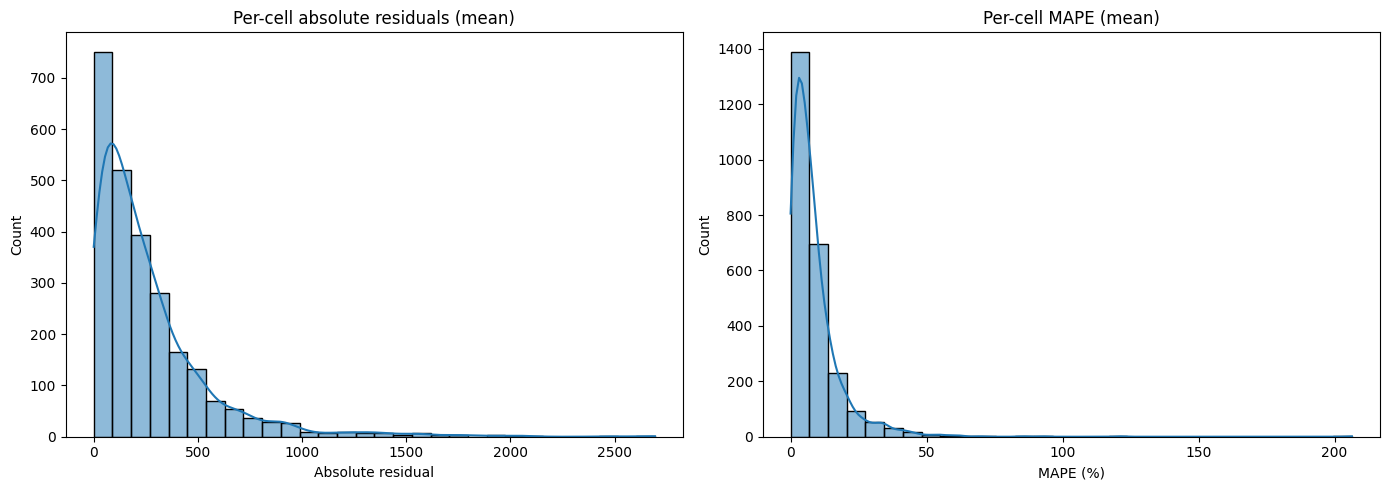

In [56]:
# Compute MAPE per cell (RF test) and residual histograms per cell
agg['abs_residual'] = np.abs(agg['residual'])
agg['mape'] = np.abs(agg['residual']) / (agg['y_true'] + eps) * 100

mape_grid = np.full((n_grid, n_grid), np.nan)
abs_res_grid = np.full((n_grid, n_grid), np.nan)
pct_res_grid = np.full((n_grid, n_grid), np.nan)

for _, row in agg.iterrows():
    i = int(row['lat_idx'])
    j = int(row['lon_idx'])
    mape_grid[i, j] = row['mape']
    abs_res_grid[i, j] = row['abs_residual']
    pct_res_grid[i, j] = row['mape']

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(mape_grid, origin='lower', aspect='auto',
               extent=[lon_min, lon_max, lat_min, lat_max], cmap='magma')
ax.set_title('MAPE per cell (RF test)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.colorbar(im, ax=ax, label='MAPE (%)')
plt.tight_layout()

# Histograms of per-cell residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(agg['abs_residual'].dropna(), bins=30, kde=True, ax=axes[0])
axes[0].set_title('Per-cell absolute residuals (mean)')
axes[0].set_xlabel('Absolute residual')

sns.histplot(agg['mape'].dropna(), bins=30, kde=True, ax=axes[1])
axes[1].set_title('Per-cell MAPE (mean)')
axes[1].set_xlabel('MAPE (%)')

plt.tight_layout()


## Spatial autocorrelation